In [1]:
import pandas as pd
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import RegexpTokenizer
from langdetect import detect
from langdetect import detect_langs
import numpy as np
import seaborn as sns
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from wordcloud import WordCloud
#nltk.downloader.download('vader_lexicon')
#nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')

In [2]:
df = pd.read_csv('./Amsterdam/amsterdam_reviews.csv')
df_test = df.head(n=100)

### 1. Cleaning reviews file (filter out nulls and non-english reviews)

In [3]:
#df_input = df_test
df_input = df
df_input.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,2818,1191,2009-03-30,10952,Lam,Daniel is really cool. The place was nice and ...
1,2818,1771,2009-04-24,12798,Alice,Daniel is the most amazing host! His place is ...
2,2818,1989,2009-05-03,11869,Natalja,We had such a great time in Amsterdam. Daniel ...
3,2818,2797,2009-05-18,14064,Enrique,Very professional operation. Room is very clea...
4,2818,3151,2009-05-25,17977,Sherwin,Daniel is highly recommended. He provided all...


In [4]:
# classify language of review
def get_language(x):
    try:
        language = detect(x)
    except:
        language = "error"

    return language
        

In [5]:
df_input['language'] = df_input["comments"].apply(get_language)

In [6]:
# save file with language classification to csv 
df_input.to_csv('./Amsterdam/amsterdam_reviews_language.csv', index=False)

In [7]:
df_input.shape

(464791, 7)

In [8]:
df_input.groupby('language').count()

,listing_id,id,date,reviewer_id,reviewer_name,comments
language,,,,,,
af,627,627,627,627,627,627
ar,36,36,36,36,36,36
bg,15,15,15,15,15,15
ca,540,540,540,540,540,540
cs,338,338,338,338,338,338
cy,135,135,135,135,135,135
da,563,563,563,563,563,563
de,19690,19690,19690,19690,19690,19690
el,82,82,82,82,82,82


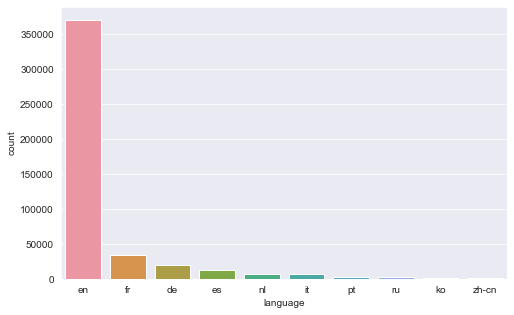

In [37]:
plt.figure(figsize = (8,5))
sns.color_palette("husl", 8)
sns.set_palette('husl')
sns.set_style("darkgrid")
sns.countplot(x='language', data=df_input, order=pd.value_counts(df_input['language']).iloc[:10].index)


## 2. Run sentiment analysis on english reviews only 

In [10]:
# run sentiment analysis on english reviews only 
df_english = df_input.loc[df_input['language'] == 'en']
df_english.shape

(370761, 7)

In [11]:
ss = SentimentIntensityAnalyzer()

In [12]:
def apply_sentiment(val, ss):
    val = str(val)
    return ss.polarity_scores(val)['compound']

In [13]:
df_english['sentiment'] = df_english['comments'].apply(apply_sentiment, ss = ss)

<ipython-input-13-e48b027d7231>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_english['sentiment'] = df_english['comments'].apply(apply_sentiment, ss = ss)


In [39]:
df_english.to_csv('./Amsterdam/amsterdam_sentiment.csv',index = False)

In [40]:
df_english.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,language,sentiment
0,2818,1191,2009-03-30,10952,Lam,Daniel is really cool. The place was nice and ...,en,0.8843
1,2818,1771,2009-04-24,12798,Alice,Daniel is the most amazing host! His place is ...,en,0.9667
2,2818,1989,2009-05-03,11869,Natalja,We had such a great time in Amsterdam. Daniel ...,en,0.9732
3,2818,2797,2009-05-18,14064,Enrique,Very professional operation. Room is very clea...,en,0.9716
4,2818,3151,2009-05-25,17977,Sherwin,Daniel is highly recommended. He provided all...,en,0.9272


## 3. Create new features based on positive and negative reviews

In [14]:
df_sent = df_english[['listing_id', 'sentiment']]
df_sent.reset_index(inplace=True)
del df_sent['index']

In [15]:
# create new column with positive and negative classifications
def sentiment_classification(x):
    if x >= 0.05 : 
        classification = 'positive' 
  
    elif x <= - 0.05 : 
        classification = 'negative'
  
    else : 
        classification = 'neutral'
    return classification
  
df_sent['sentiment_class'] = df_sent['sentiment'].apply(sentiment_classification)
df_sent.head()

<ipython-input-15-9c187e4199fe>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sent['sentiment_class'] = df_sent['sentiment'].apply(sentiment_classification)


,listing_id,sentiment,sentiment_class
0,2818,0.8843,positive
1,2818,0.9667,positive
2,2818,0.9732,positive
3,2818,0.9716,positive
4,2818,0.9272,positive


In [16]:
#create two new features, avg_sentiment_score and proportion_positive

def pos_proportion(x):
    v = np.sum(x=='positive')/len(x)
    return v 

df_avg_sent = df_sent.groupby('listing_id', group_keys = False, as_index = False).agg({
    'sentiment': np.mean,
    'sentiment_class' : pos_proportion})

In [17]:
df_avg_sent.head()

,listing_id,sentiment,sentiment_class
0,2818,0.898851,0.982979
1,20168,0.783318,0.932862
2,25428,0.939460,1.000000
3,27886,0.909413,0.983240
4,28871,0.867427,0.988095


In [18]:
df_avg_sent.rename(columns={'sentiment': 'avg_sentiment_score', 'sentiment_class': 'proportion_positive'}, inplace=True)
df_avg_sent.to_csv('./Amsterdam/amsterdam_sentiment_features.csv', index = False)

## Exploratory sentiment analysis

In [47]:
df_neighborhoods = pd.read_csv('../data_input/Amsterdam/amsterdam_listings_full.csv')
df_neighborhoods.head()

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2818,https://www.airbnb.com/rooms/2818,20201009050447,2020-10-11,Quiet Garden View Room & Super Fast WiFi,Quiet Garden View Room & Super Fast WiFi<br />...,"Indische Buurt (""Indies Neighborhood"") is a ne...",https://a0.muscache.com/pictures/10272854/8dcc...,3159,https://www.airbnb.com/users/show/3159,...,10.0,9.0,10.0,NaN,t,1,0,1,0,1.98
1,20168,https://www.airbnb.com/rooms/20168,20201009050447,2020-10-11,Studio with private bathroom in the centre 1,17th century Dutch townhouse in the heart of t...,Located just in between famous central canals....,https://a0.muscache.com/pictures/69979628/fd6a...,59484,https://www.airbnb.com/users/show/59484,...,10.0,10.0,9.0,NaN,t,2,0,2,0,2.63
2,25428,https://www.airbnb.com/rooms/25428,20201009050447,2020-10-11,Lovely apt in City Centre (w.lift) near Jordaan,Lovely apt in Centre ( lift & fireplace) near ...,NaN,https://a0.muscache.com/pictures/138431/7079a9...,56142,https://www.airbnb.com/users/show/56142,...,10.0,10.0,10.0,NaN,f,1,1,0,0,0.15
3,27886,https://www.airbnb.com/rooms/27886,20201009050447,2020-10-10,"Romantic, stylish B&B houseboat in canal district",Stylish and romantic houseboat on fantastic hi...,"Central, quiet, safe, clean and beautiful.",https://a0.muscache.com/pictures/02c2da9d-660e...,97647,https://www.airbnb.com/users/show/97647,...,10.0,10.0,10.0,NaN,t,1,0,1,0,2.05
4,28871,https://www.airbnb.com/rooms/28871,20201009050447,2020-10-10,Comfortable double room,<b>The space</b><br />In a monumental house ri...,"Flower market , Leidseplein , Rembrantsplein",https://a0.muscache.com/pictures/160889/362340...,124245,https://www.airbnb.com/users/show/124245,...,10.0,10.0,10.0,NaN,f,2,0,2,0,2.72


In [46]:
df = pd.read_csv('./Amsterdam/amsterdam_sentiment.csv')
df_neighborhoods = pd.read_csv('../data_input/Amsterdam/amsterdam_listings_full.csv')
df_neighborhoods = df_neighborhoods[['id', 'neighbourhood_group_cleansed']]
df_neighborhoods.head()

,id,neighbourhood_group_cleansed
0,2818,NaN
1,20168,NaN
2,25428,NaN
3,27886,NaN
4,28871,NaN


### Show sentiment by borough

In [34]:
df_merged = pd.merge(df, df_neighborhoods,  how='left', left_on=['listing_id'], right_on = ['id'])
df_merged.head()

,listing_id,id_x,date,reviewer_id,reviewer_name,comments,language,sentiment,id_y,neighbourhood_group_cleansed
0,2595,19760,2009-12-10,38960,Anita,I've stayed with my friend at the Midtown Cast...,en,0.9248,2595,Manhattan
1,2595,34320,2010-04-09,71130,Kai-Uwe,"We've been staying here for about 9 nights, en...",en,0.9229,2595,Manhattan
2,2595,46312,2010-05-25,117113,Alicia,We had a wonderful stay at Jennifer's charming...,en,0.9464,2595,Manhattan
3,2595,1238204,2012-05-07,1783688,Sergey,Hi to everyone!\r\nWould say our greatest comp...,en,0.9869,2595,Manhattan
4,2595,1293632,2012-05-17,1870771,Loïc,"Jennifer was very friendly and helpful, and he...",en,0.9668,2595,Manhattan


In [35]:
df_merged.drop(columns=['id_y'], inplace=True)

In [38]:
df_avg_sent_borough = df_merged.groupby('neighbourhood_group_cleansed', group_keys=False, as_index=False).agg({'sentiment': np.mean})
df_avg_sent_borough

,neighbourhood_group_cleansed,sentiment
0,Bronx,0.783458
1,Brooklyn,0.835924
2,Manhattan,0.819786
3,Queens,0.785524
4,Staten Island,0.817085


In [38]:
x = df_avg_sent_borough['neighbourhood_group_cleansed']
plt.figure(figsize = (8,5))
sns.color_palette("husl", 8)
sns.set_palette('husl')
sns.set_style("darkgrid")
sns.barplot(x, y, palette='viridis')

NameError: name 'df_avg_sent_borough' is not defined

In [ ]:
df_merged['sentiment_class'] = df_sent['sentiment'].apply(sentiment_classification)
df_avg_sent_borough = df_merged.groupby('neighbourhood_group_cleansed', group_keys=False, as_index=False).agg({'sentiment': np.mean})

### Get distribution of languages of reviews

In [50]:
df_reviews_lang = pd.read_csv('reviews_with_lang.csv')
#count = df_reviews_lang.language.value_counts().iloc[:5]


AttributeError: 'Series' object has no attribute 'columns'

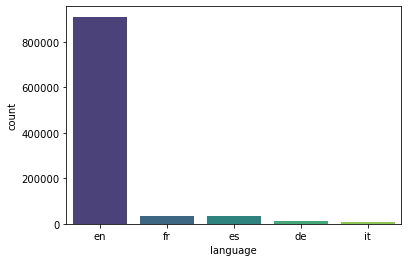

In [56]:
sns.countplot(x='language',data=df_reviews_lang,order=pd.value_counts(df_reviews_lang['language']).iloc[:5].index, palette='viridis')

## Generate word cloud

In [2]:
df = pd.read_csv('./Amsterdam/amsterdam_sentiment.csv')
df.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,language,sentiment
0,2818,1191,2009-03-30,10952,Lam,Daniel is really cool. The place was nice and ...,en,0.8843
1,2818,1771,2009-04-24,12798,Alice,Daniel is the most amazing host! His place is ...,en,0.9667
2,2818,1989,2009-05-03,11869,Natalja,We had such a great time in Amsterdam. Daniel ...,en,0.9732
3,2818,2797,2009-05-18,14064,Enrique,Very professional operation. Room is very clea...,en,0.9716
4,2818,3151,2009-05-25,17977,Sherwin,Daniel is highly recommended. He provided all...,en,0.9272


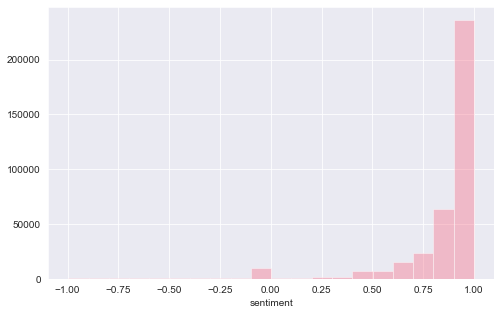

In [3]:
plt.figure(figsize = (8,5))
sns.color_palette("husl", 8)
sns.set_palette('husl')
sns.set_style("darkgrid")
sns.distplot(df['sentiment'], kde = False, bins = 20)

In [4]:
df.shape

(370761, 8)

In [5]:
df_positive = df[df['sentiment']>.98]['comments']

In [6]:
df_neg = df[df['sentiment']<.05]['comments']

In [7]:
pos_text = ' '.join(list(df_positive))

post_text = pos_text.replace('\r','')
post_text = pos_text.replace('\n','')

In [8]:
neg_text = ' '.join(list(df_neg))

neg_text = neg_text.replace('\r','')
neg_text = neg_text.replace('\n','')

In [21]:
# Generate a word cloud image
wordcloud = WordCloud(background_color="white", max_words=200, contour_width=3, contour_color='steelblue')

wordcloud.generate(pos_text, )


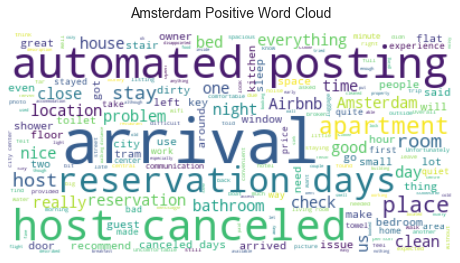

In [35]:
# Display the generated image:
# the matplotlib way:
plt.figure(figsize = (8,5))
plt.title('Amsterdam Positive Word Cloud', fontsize=14, pad=15)
plt.imshow(wordcloud, interpolation='bilinear',)
plt.axis("off")

plt.savefig('./Amsterdam/am_pos_word_cloud.png', bbox_inches='tight')

In [20]:
# save wordcloud 
plt.savefig('./Amsterdam/am_pos_word_cloud.png')
plt.show()
#wordcloud.to_file('./Amsterdam/am_pos_word_cloud.png')

<Figure size 432x288 with 0 Axes>

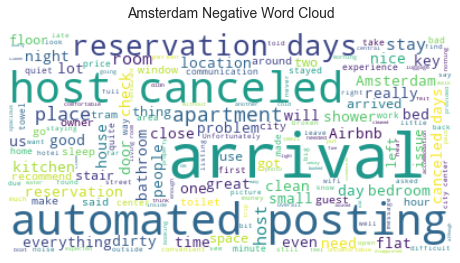

In [36]:
# Generate a word cloud image
wordcloud = WordCloud(background_color="white", max_words=200, contour_width=3, contour_color='steelblue')
wordcloud.generate(neg_text,)

# Display the generated image:
# the matplotlib way:
import matplotlib.pyplot as plt
plt.figure(figsize = (8, 5))
plt.title('Amsterdam Negative Word Cloud', fontsize=14, pad=15)
plt.imshow(wordcloud, interpolation='bilinear',)
plt.axis("off")

plt.savefig('./Amsterdam/am_neg_word_cloud.png', bbox_inches='tight')